# PART 3: MODEL ANALYSIS

**Objective:** This notebook will construct an appropriate model and execute the technician-navigation application in order to study the potential benefits in productivity and operational costs.

---

In [400]:
# Data Management
import numpy as np
import pandas as pd
from prettytable import PrettyTable

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_regression, mutual_info_regression, f_classif
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, explained_variance_score 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from yellowbrick.model_selection import FeatureImportances, LearningCurve, ValidationCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from pandas.plotting import autocorrelation_plot


# Utils
import ast
import datetime
import ipywidgets as widgets
import pprint
import random
import warnings
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual
from random import choice, choices, shuffle, randrange
from time import sleep
%matplotlib inline
sns.set_style('white')
sns.set_color_codes()
plt.style.use('default')
warnings.filterwarnings("ignore")
pp = pprint.PrettyPrinter(indent=0)

---
---

## 3A: Setup

**Objective**: Read in the clinic data & necessary patient records files.

---

In [258]:
past_patients_df = pd.read_csv('./uc_past_patients.csv', index_col='pt_id')
past_patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code,assigned_num_techs,needed_num_techs
pt_id,,,,,,,,,,,,,,
1000025,Tracy Hernandez,2020-07-26,1,denver,drug-test,3,2021-05-01,Saturday,08:31:51,08:58:51,1,0.0,4,1
1000007,Debra Huerta,1994-08-31,27,denver,diarrhea,5,2021-05-01,Saturday,08:36:07,09:35:07,2,3.0,4,1
1000011,Meghan Richards,2021-06-09,0,denver,diarrhea,5,2021-05-01,Saturday,08:37:27,09:40:27,3,4.0,4,1
1000008,Karen Donovan,1998-02-06,24,denver,ache/pain,4,2021-05-01,Saturday,09:09:12,09:53:12,3,5.0,4,1
1000004,Christopher Clark Jr.,1963-07-31,58,denver,covid-test,4,2021-05-01,Saturday,09:19:49,09:52:13,4,4.7,4,2


In [259]:
new_patients_df = pd.read_csv('./uc_new_patients.csv', index_col='pt_id')
new_patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code,assigned_num_techs,needed_num_techs
pt_id,,,,,,,,,,,,,,
1026390,James Gutierrez,1987-09-14,34,denver,ache/pain,4,2022-05-01,Sunday,08:35:08,09:16:08,1,0.0,4,1
1026381,Michael Barry,1983-08-16,38,denver,vaccination,3,2022-05-01,Sunday,08:35:38,08:56:38,2,4.0,4,1
1026376,Deborah Evans DDS,1950-09-20,71,denver,drug-test,3,2022-05-01,Sunday,08:38:55,09:16:55,3,3.5,4,1
1026388,Caitlin Roach,1990-12-30,31,denver,lab-work,3,2022-05-01,Sunday,08:51:48,09:39:48,3,3.5,4,1
1026392,Nancy Gilbert,1991-08-04,30,denver,covid-test,4,2022-05-01,Sunday,09:14:56,09:47:56,3,3.5,4,1


In [260]:
clinics_df = pd.read_csv('./uc_clinics.csv', index_col='branch_name')
# clinics_df

---
---

## 3B: Data Processing

**Objective**: Execute minor cleaning implementations due to lost data characteristics from CSV read-in.

---

#### Convert nearby_clinics info from str to original list format:

In [261]:
clinics_df['nearby_clinics'] = clinics_df.nearby_clinics.apply(lambda x: ast.literal_eval(x))  

In [262]:
clinics_df

,lat,lon,to_denver,to_edgewater,to_wheatridge,to_rino,to_lakewood,nearby_clinics
branch_name,,,,,,,,
denver,39.739064,-104.989697,0,12,14,7,14,"[(rino, 7.0), (edgewater, 12.0), (wheatridge, ..."
edgewater,39.753954,-105.067788,14,0,5,12,9,"[(wheatridge, 5.0), (lakewood, 9.0), (rino, 12..."
wheatridge,39.766857,-105.081983,14,5,0,10,9,"[(edgewater, 5.0), (lakewood, 9.0), (rino, 10...."
rino,39.767328,-104.981132,6,14,14,0,14,"[(denver, 6.0), (edgewater, 14.0), (wheatridge..."
lakewood,39.704552,-105.079883,12,8,8,12,0,"[(edgewater, 8.0), (wheatridge, 8.0), (denver,..."


#### Create appropriate datetime objects for visit date & check-in/out times:

In [263]:
def clean_pt_records(df):
    """Convers datetime info to appropriate formats from csv read-in data."""
    
    # Create unified date/time attribute for sorting purposes
    datetime_str = []
    for i in zip(df.visit_date, df.checkin_time):
        datetime_str.append(i[0] + ' ' + i[1])
    df['datetime'] = datetime_str

    # Sort based on datetime strings
    df = df.sort_values('datetime') #[50:200]

    # Rearrange column order
    df = df[['datetime'] + df.columns.tolist()[:-1]]
    
    # Convert visit date & check-in/out columns to datetime objects (csv converts them into strings)
    df['visit_date'] = df.visit_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')).apply(lambda x: x.date())
    df['checkin_time'] = df.checkin_time.apply(lambda x: datetime.strptime(x, '%H:%M:%S')).apply(lambda x: x.time())
    df['checkout_time'] = df.checkout_time.apply(lambda x: datetime.strptime(x, '%H:%M:%S')).apply(lambda x: x.time())
    
    return df

In [264]:
past_patients_df = clean_pt_records(past_patients_df)
new_patients_df = clean_pt_records(new_patients_df)


#### Feature engineer new columns

In [265]:
# Weekend column - 1 for weekend, 0 for weekenday
def feature_engineer(df):
    df['weekend'] = df['visit_day'].copy().apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    df['hour'] = df['checkin_time'].copy().apply(lambda x: x.hour)
    df = pd.concat([df, pd.get_dummies(df['visit_location'])], axis=1)
    df['hour'] = df.hour.astype('category')
    # print(df.dtypes)
    return df

In [266]:
new_patients_df = feature_engineer(new_patients_df)
past_patients_df = feature_engineer(past_patients_df)

In [267]:
past_patients_df

,datetime,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,...,rolling_code,assigned_num_techs,needed_num_techs,weekend,hour,denver,edgewater,lakewood,rino,wheatridge
pt_id,,,,,,,,,,,,,,,,,,,,,
2000017,2021-05-01 08:06:44,Catherine Riley,1944-10-27,77,edgewater,ache/pain,4,2021-05-01,Saturday,08:06:44,...,0.0,3,1,1,8,0,1,0,0,0
2000009,2021-05-01 08:08:56,Connor Murray,1974-03-02,48,edgewater,vaccination,3,2021-05-01,Saturday,08:08:56,...,4.0,3,1,1,8,0,1,0,0,0
4000002,2021-05-01 08:21:47,Lucas Mccullough,2021-02-16,1,rino,cold/flu/fever,4,2021-05-01,Saturday,08:21:47,...,0.0,4,1,1,8,0,0,0,1,0
4000014,2021-05-01 08:24:19,Stephanie Pineda,1989-05-08,33,rino,cough,4,2021-05-01,Saturday,08:24:19,...,4.0,4,1,1,8,0,0,0,1,0
2000012,2021-05-01 08:24:34,Eric Barr,1980-10-10,41,edgewater,ear-pain,4,2021-05-01,Saturday,08:24:34,...,3.5,3,1,1,8,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021256,2022-04-30 19:41:38,Jennifer Shaw,1984-10-28,37,wheatridge,rash/allergy,5,2022-04-30,Saturday,19:41:38,...,4.3,3,2,1,19,0,0,0,0,1
1026353,2022-04-30 19:45:55,Rhonda Cardenas,1981-06-28,40,denver,vaccination,3,2022-04-30,Saturday,19:45:55,...,0.0,4,1,1,19,1,0,0,0,0
1026364,2022-04-30 19:48:35,Stephen Browning,1962-11-01,59,denver,headache,5,2022-04-30,Saturday,19:48:35,...,3.0,4,1,1,19,1,0,0,0,0


---
---

## 3C: Modeling Part I

**Objective**: Construct, validate, and evaluate traditional ML models to predict techs-needed at a particular time & location based on past patient records.

---

#### Data Partitioning:

In [268]:
X = past_patients_df[['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood', 'weekend', 'hour']].copy()
y = past_patients_df['needed_num_techs'].copy()

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

#### Baseline Modeling:

In [270]:
def fit_model(model, X, y, table):
    """Constructs a given model based on input data and evaluates results among relevant metrics."""
    
    model = model.fit(X, y)
    pred = model.predict(X)
    r2 = round(r2_score(y, pred), 2)
    mae = round(mean_absolute_error(y, pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y, pred)), 2)
    medae = round(median_absolute_error(y, pred), 2)  
    mape = round(mean_absolute_percentage_error(y, pred),2) 
    table.add_row([model, r2, mae, rmse, medae, mape])
    return table

def exec_regr(X, y, rs=42):
    """Executes streamlined-process using the input target variable."""
    
    # Define set of baseline models to iterate through
    models = [
        LinearRegression(),
        Lasso(random_state=rs),
        ElasticNet(random_state=rs),
        Ridge(random_state=rs),
        KNeighborsRegressor(),
        # SVR()
        DecisionTreeRegressor(random_state=rs),
        RandomForestRegressor(random_state=rs),
    ]

    # Instantiate a tabular structure to store results from each model
    table = PrettyTable()
    table.field_names = ['Model', 'R2', 'MAE', 'RMSE', 'MedAE', 'MAPE']
    
    # Execute model
    for model in models:
        table = fit_model(model, X, y, table)

    return table

print(exec_regr(X_train, y_train))

+----------------------------------------+------+------+------+-------+------+
|                 Model                  |  R2  | MAE  | RMSE | MedAE | MAPE |
+----------------------------------------+------+------+------+-------+------+
|           LinearRegression()           | 0.1  | 0.64 | 0.8  |  0.57 | 0.4  |
|         Lasso(random_state=42)         | 0.0  | 0.6  | 0.85 |  0.99 | 0.39 |
|      ElasticNet(random_state=42)       | 0.0  | 0.6  | 0.85 |  0.99 | 0.39 |
|         Ridge(random_state=42)         | 0.1  | 0.64 | 0.8  |  0.57 | 0.4  |
|         KNeighborsRegressor()          | 0.15 | 0.62 | 0.78 |  0.6  | 0.37 |
| DecisionTreeRegressor(random_state=42) | 0.29 | 0.57 | 0.72 |  0.49 | 0.35 |
| RandomForestRegressor(random_state=42) | 0.29 | 0.57 | 0.72 |  0.49 | 0.35 |
+----------------------------------------+------+------+------+-------+------+


The table above shows the scoring of various baseline regression models, evaluated among relevant metrics. From this, we can assess the tree-based models outperform all others and should be tuned further to see if the scoring can be improved.

#### Model Tuning (for best baseline performer):

In [17]:
# param_grid = [{
#     "n_estimators": [40, 70, 100],
#     "max_depth": [6, 8, 10]
# }]

# gs = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3) 
# gs.fit(X_train, y_train)
# rf = gs.best_estimator_

# print(rf)

# train_pred = rf.predict(X_train)
# test_pred = rf.predict(X_test)

# print('RMSE of training set predictions: ', np.sqrt(mean_squared_error(y_train, train_pred)))
# print('RMSE of test set predictions: ', np.sqrt(mean_squared_error(y_test, test_pred)))

RandomForestRegressor(max_depth=10, random_state=42)
RMSE of training set predictions:  0.7152771387392919
RMSE of test set predictions:  0.7156812843047556


In [271]:
rf = RandomForestRegressor(max_depth=10, random_state=42)  # best model from grid search above

#### Visualize results:

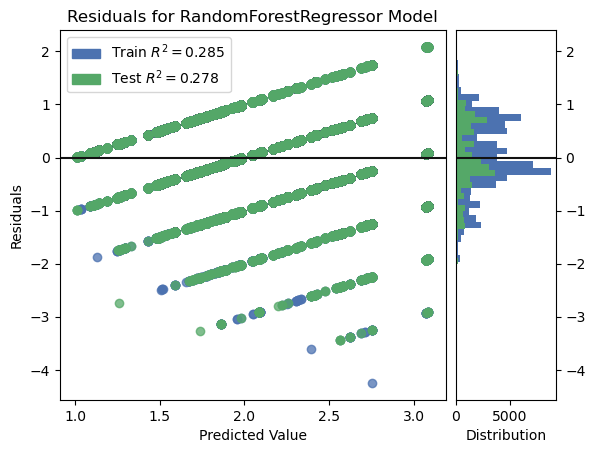

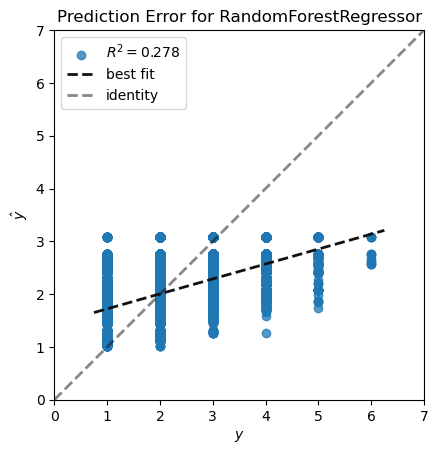

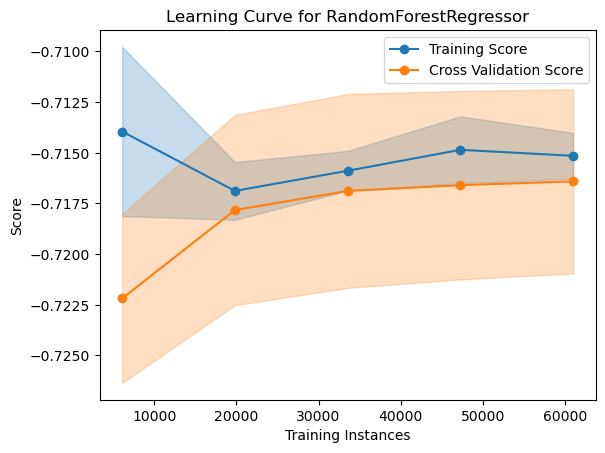

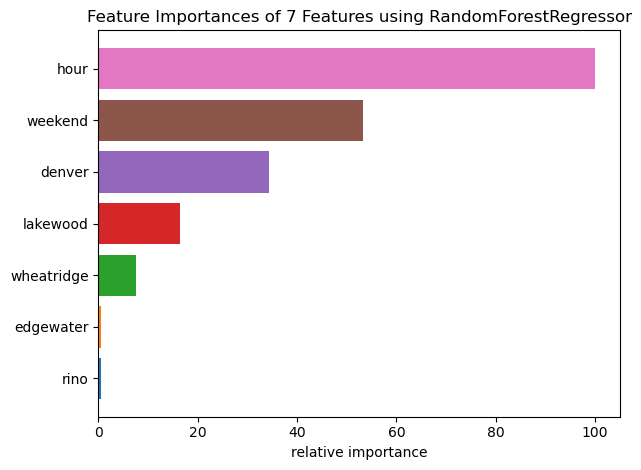

<AxesSubplot:title={'center':'Feature Importances of 7 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [272]:
residuals_plot = ResidualsPlot(rf)
residuals_plot.fit(X_train, y_train).score(X_test, y_test)
residuals_plot.show()

pred_err_plot = PredictionError(rf)
pred_err_plot.fit(X_train, y_train).score(X_test, y_test)
pred_err_plot.show()

lc = LearningCurve(rf, scoring='neg_root_mean_squared_error', cv=5)
lc.fit(X_train, y_train).score(X_test, y_test)
lc.show()

fi = FeatureImportances(rf)
fi.fit(X_train, y_train).score(X_test, y_test)
fi.show()

Take-Aways:

Further model tuning to optimize the best baseline perform (tree-based random-forest) still doesn't improve RMSE score for our target variable. However, the model does seem to generalize well to the test-set which is to be expected due to the fact that this project involved generating the source datasets. 
RMSE of around 1 indicates that the model is, on average, off by 1 tech in predicting how many a clinic needs at any given moment in time, for any location. Since majority of the instances involve more than 1 available tech at a nearby clinic, this model will only need to be executed occasionally throughout the day for the TecNav navigator app. Nonetheless, an alternative forecasting approach will be conducted below.

---
---

## 3C: Modeling Part II

**Objective**: Construct, validate, and evaluate time series analyses to predict rolling count based on past patient records.

---

#### Feature engineering to prepare data for Time-Series:

In [309]:
filtered_df = past_patients_df[['visit_date', 'visit_location', 'checkin_time', 'needed_num_techs']].copy()
filtered_df['visit_date'] = filtered_df.visit_date.apply(lambda x: str(x))

def floor_dt(current):
    today = date.today()
    current = datetime.combine(today, current)
    rounded_time = current - (current - datetime.min) % timedelta(minutes=15)
    return str(rounded_time.time())[:-3]
filtered_df['interval_time'] = filtered_df.checkin_time.apply(lambda x: floor_dt(x))

filtered_df = filtered_df.groupby(['visit_date', 'visit_location', 'interval_time']).median().round().reset_index(drop=False).sort_values(by=['visit_location', 'visit_date', 'interval_time'])
filtered_df = filtered_df.sort_values(by=['visit_date', 'interval_time', 'visit_location'])
filtered_df

,visit_date,visit_location,interval_time,needed_num_techs
38,2021-05-01,edgewater,08:00,1.0
39,2021-05-01,edgewater,08:15,1.0
101,2021-05-01,rino,08:15,1.0
0,2021-05-01,denver,08:30,1.0
102,2021-05-01,rino,08:30,2.0
...,...,...,...,...
59631,2022-04-30,lakewood,19:30,3.0
59664,2022-04-30,rino,19:30,1.0
59693,2022-04-30,wheatridge,19:30,1.0
59568,2022-04-30,denver,19:45,1.0


In [310]:
filtered_df = filtered_df[filtered_df.visit_date.str.contains('2021-05')]

all_intervals = filtered_df.interval_time.unique()
rows = []
for d in filtered_df.visit_date.unique():
    for i in all_intervals:
        rows.append([d, 'denver', i])
        rows.append([d, 'wheatridge', i])
        rows.append([d, 'edgewater', i])
        rows.append([d, 'rino', i])
        rows.append([d, 'lakewood', i])
ts_df = pd.DataFrame(rows, columns=['visit_date', 'visit_location', 'time'])

ts_df = ts_df.sort_values(by=['visit_date', 'time', 'visit_location'])
ts_df

,visit_date,visit_location,time
0,2021-05-01,denver,08:00
2,2021-05-01,edgewater,08:00
4,2021-05-01,lakewood,08:00
3,2021-05-01,rino,08:00
1,2021-05-01,wheatridge,08:00
...,...,...,...
7435,2021-05-31,denver,19:45
7437,2021-05-31,edgewater,19:45
7439,2021-05-31,lakewood,19:45
7438,2021-05-31,rino,19:45


In [311]:
ts_df['needed_num_techs'] = ts_df[['visit_location', 'visit_date', 'time']].apply(lambda x: filtered_df[
    (filtered_df.visit_location == x[0]) & (filtered_df.visit_date == x[1]) & (filtered_df.interval_time == x[2])
]['needed_num_techs'].values, axis=1)
ts_df['needed_num_techs'] = ts_df['needed_num_techs'].apply(lambda x: x[0] if len(x)>0 else np.nan)
ts_df = ts_df.fillna(method='ffill')
ts_df = ts_df.fillna(1)
ts_df

,visit_date,visit_location,time,needed_num_techs
0,2021-05-01,denver,08:00,1.0
2,2021-05-01,edgewater,08:00,1.0
4,2021-05-01,lakewood,08:00,1.0
3,2021-05-01,rino,08:00,1.0
1,2021-05-01,wheatridge,08:00,1.0
...,...,...,...,...
7435,2021-05-31,denver,19:45,2.0
7437,2021-05-31,edgewater,19:45,2.0
7439,2021-05-31,lakewood,19:45,2.0
7438,2021-05-31,rino,19:45,2.0


In [340]:
ts_df['dt'] = ts_df[['visit_date', 'time']].apply(lambda x: x[0] + ' ' + x[1], axis=1)

In [471]:
denver_df = ts_df[ts_df.visit_location == 'denver']
wheatridge_df = ts_df[ts_df.visit_location == 'wheatridge']
edgewater_df = ts_df[ts_df.visit_location == 'edgewater']
rino_df = ts_df[ts_df.visit_location == 'rino']
lakewood_df = ts_df[ts_df.visit_location == 'lakewood']

#### ARIMA:

In [472]:
denver_df

,visit_date,visit_location,time,needed_num_techs,dt
0,2021-05-01,denver,08:00,1.0,2021-05-01 08:00
5,2021-05-01,denver,08:15,1.0,2021-05-01 08:15
10,2021-05-01,denver,08:30,1.0,2021-05-01 08:30
15,2021-05-01,denver,08:45,2.0,2021-05-01 08:45
20,2021-05-01,denver,09:00,1.0,2021-05-01 09:00
...,...,...,...,...,...
7415,2021-05-31,denver,18:45,1.0,2021-05-31 18:45
7420,2021-05-31,denver,19:00,1.0,2021-05-31 19:00
7425,2021-05-31,denver,19:15,1.0,2021-05-31 19:15
7430,2021-05-31,denver,19:30,1.0,2021-05-31 19:30


In [473]:
denver_df = denver_df[denver_df.visit_date.isin(['2021-05-03', '2021-05-04',
       '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-08',
       '2021-05-09'])]

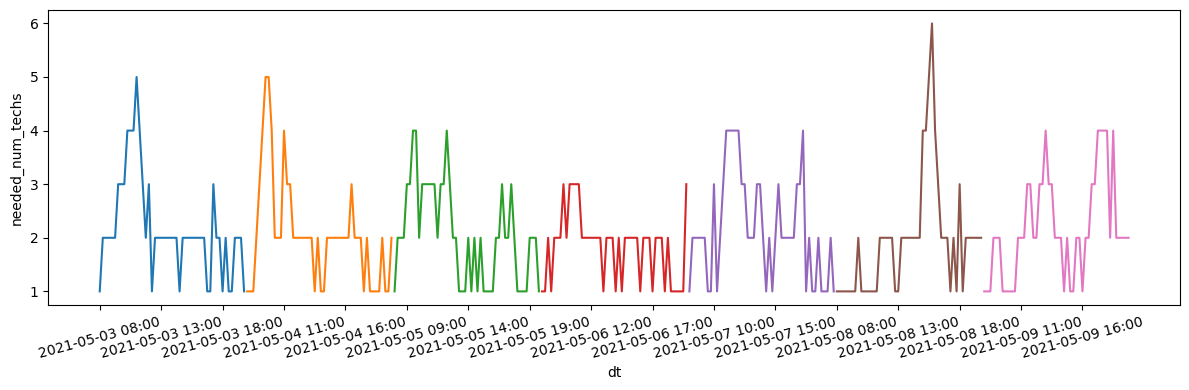

In [496]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(x=denver_df['dt'], y=denver_df['needed_num_techs'], hue=denver_df['visit_date'], legend=False)
plt.xticks(denver_df.dt.tolist()[0::20],  rotation=15)
plt.tight_layout()
plt.show()

#### Test for stationarity:

In [497]:
denver_df = denver_df.set_index('dt')[['needed_num_techs']]

In [498]:
#Ho: It is non stationary
#H1: It is stationary

adf_results = adfuller(denver_df)
print('ADF Test Statistic: ', adf_results[0])
print('p-value: ', adf_results[1])
print('# of Lags Used: ', adf_results[2])
print('# of Obs. Used: ', adf_results[3])

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

ADF Test Statistic:  -6.393478079011247
p-value:  2.0781867199569106e-08
# of Lags Used:  2
# of Obs. Used:  333
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


The NullH of ADF is the data is non stationary. The p-value below the level of significance (0.05) indicates strong evidence against the null hypothesis(Ho) enabling us to reject it and retain the alternate that the data has no unit root and is stationary. Therefore, ARMA/ARIMA models are feasible with this data. Furthermore, the ADF results indiciate no further need to implement any differencing to transform the data into stationary.


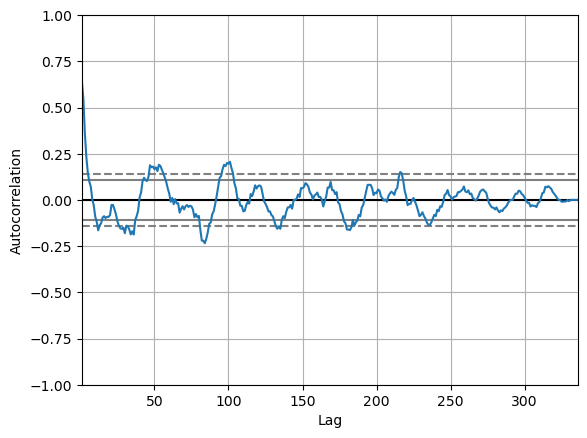

In [436]:
autocorrelation_plot(denver_df.needed_num_techs)
plt.show()

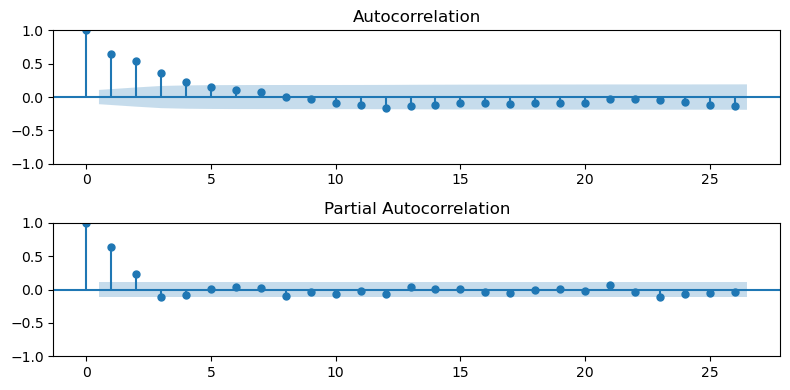

In [440]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

plot_acf(denver_df.needed_num_techs, ax=ax[0])
plot_pacf(denver_df.needed_num_techs, ax=ax[1])

plt.tight_layout()
plt.show()

 4,0,2

                               SARIMAX Results                                
Dep. Variable:       needed_num_techs   No. Observations:                  336
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -347.099
Date:                Tue, 17 May 2022   AIC                            712.198
Time:                        00:21:57   BIC                            746.552
Sample:                             0   HQIC                           725.892
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9998      0.020    101.138      0.000       1.961       2.039
ar.L1          0.7062      0.063     11.145      0.000       0.582       0.830
ar.L2          0.9430      0.040     23.485      0.0

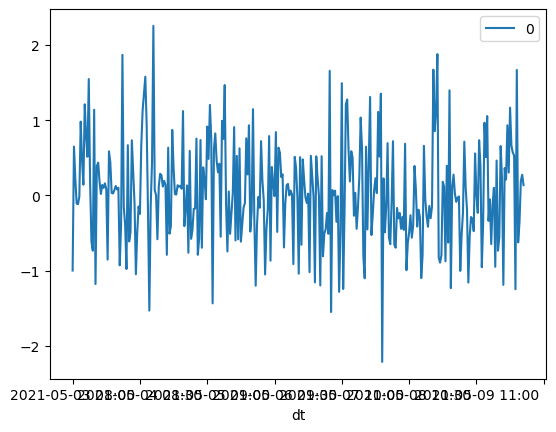

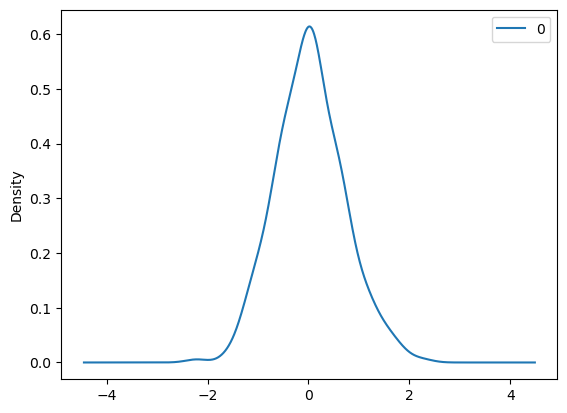

                0
count  336.000000
mean     0.031162
std      0.680431
min     -2.215114
25%     -0.447495
50%      0.020364
75%      0.479619
max      2.253071


In [499]:
# fit model
model = ARIMA(denver_df.needed_num_techs, order=(3,0,4))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Test RMSE:  0.758


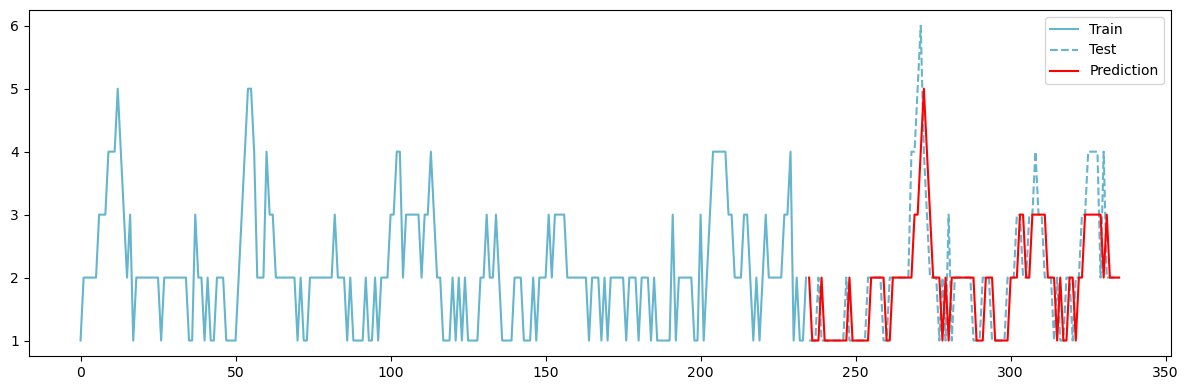

In [529]:
# split into train and test sets
X = denver_df.needed_num_techs.values

size = int(len(X) * 0.7)  # 235
train, test = X[0:size], X[size:len(X)]
history = [i for i in X]
predictions = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, [round(i) for i in predictions]))
print('Test RMSE: ', round(rmse, 3))


# plot forecasts against actual outcomes
fig, ax = plt.subplots(1,1,figsize=(12, 4))
plt.plot(X[:235], 'c-')
plt.plot([i for i in range(235, len(X))], X[235:], 'c--')
plt.plot([i for i in range(235, len(X))], [round(i) for i in predictions], color='red')

plt.tight_layout()
plt.legend(['Train', 'Test', 'Prediction'])
plt.show()

#### Conduct time-series (ARIMA) study on for an entire month for each location to examine mean RMSE:

In [468]:
from time import time
t1 = time()
def exec_arima(loc):
    """Conducts ARIMA time-series analysis for input location and outputs RMSE averaged out for all dates."""
    
    # Keep track of daily RMSE values
    rmses = []
    
    # Iterate through each day of past year dataset
    for dat in ts_df.visit_date.unique().astype('str'):
        
        # Filter dataset for specified location and aggragate interval times
        df = ts_df[(ts_df.visit_date == dat) & (ts_df.visit_location == loc)].copy()
        df = df[['time', 'needed_num_techs']]
        df = df.groupby('time').median()
        
        # Fit ARIMA model for the day and track predictions
        X = df.values
        history = [i for i in X]
        preds = []
        for t in range(len(X)):
            ar = ARIMA(history, order=(1,0,1))
            ar_fit = ar.fit()
            pred = ar_fit.forecast()
            preds.append(pred[0])
            history.append(X[t])
        rmse = np.sqrt(mean_squared_error(X, preds))
        rmses.append(rmse)    
    
    return np.mean(rmses)

print("Mean RMSE for Denver via ARIMA: ", exec_arima('denver'))
print("Mean RMSE for Edgewater via ARIMA: ", exec_arima('edgewater'))
print("Mean RMSE for Wheatridge via ARIMA: ", exec_arima('wheatridge'))
print("Mean RMSE for Rino via ARIMA: ", exec_arima('rino'))
print("Mean RMSE for Lakewood via ARIMA: ", exec_arima('lakewood'))
time()-t1

Mean RMSE for Denver via ARIMA:  0.6863962211581365
Mean RMSE for Edgewater via ARIMA:  0.7156021937166543
Mean RMSE for Wheatridge via ARIMA:  0.6674529882378971
Mean RMSE for Rino via ARIMA:  0.6461039226432352
Mean RMSE for Lakewood via ARIMA:  0.6729747285914768


174.6159689426422

The above study shows similar RMSE scores to the random forest regressor, meaning that the ARIMA model is performing on par (for the month of May 2021). Due to the extra time and model complexity of implementing this time series within the TecNav algorithm, the optimized random forest is the better choice to move forward with at this point.

---
---

## 3E: Technician Navigation

**Objective**: Implement technician navigation strategies based on past patient records.

---

Use past patients for ML part, feed new patients to model.

### Re-calibrate scheduling to a lower number of assigned techs per clinic:

In [21]:
### APPROACH 1: REDUCE NUMBER OF CLIENT-BASED SCHEDULED TECHNICIANS ("old way") BY SPECIFIED AMOUNT 

# Define variables based on desired specs
reduce_by = 1

# Reduce tech assignments by specified amount
past_patients_df['new_num_techs'] = past_patients_df.assigned_num_techs.apply(lambda x: x-1)
new_patients_df['new_num_techs'] = new_patients_df.assigned_num_techs.apply(lambda x: x-1)
new_patients_df[['visit_location', 'visit_date', 'assigned_num_techs', 'new_num_techs']]

,visit_location,visit_date,assigned_num_techs,new_num_techs
pt_id,,,,
4020227,rino,2022-05-01,4,3
4020228,rino,2022-05-01,4,3
4020229,rino,2022-05-01,4,3
4020232,rino,2022-05-01,4,3
4020230,rino,2022-05-01,4,3
...,...,...,...,...
3023134,wheatridge,2022-05-31,4,3
2019594,edgewater,2022-05-31,3,2
5025139,lakewood,2022-05-31,5,4


In [22]:
# ### APPROACH 2: REDUCE NUMBER OF CLIENT-BASED SCHEDULED TECHNICIANS ("old way") BY DESIRED QUANTILE 

# # Define variables based on desired specs
# q = 0.75

# # Retrieve specified quantile rolling count based on each day/location's aggregated data
# schedule_df = df.groupby(['visit_location', 'visit_date', 'visit_day']) \
#     .quantile(q=q).reset_index(drop=False)[['visit_location', 'visit_date', 'rolling_ct']]

# # Compute new tech assignments based on desired quantile of rolling patient count
# schedule_df['new_num_techs'] = schedule_df.rolling_ct.apply(lambda x: int(x/3)+1 if x%3 != 0 else int(x/3))

# # Create dictionary object consisting of assigned number of techs per date&location
# schedule_zipper = zip(schedule_df.visit_date, schedule_df.visit_location, schedule_df.new_num_techs)
# schedule_dict = {}
# for i in schedule_zipper:
#     schedule_dict[(i[0], i[1])] = i[2]

# # Assign techs in patient logs based on created dictionary
# df['new_num_techs'] = df[['visit_date', 'visit_location']] \
#     .apply(lambda x: (x[0], x[1]), axis=1) \
#     .map(schedule_dict)

In [23]:
cols = new_patients_df.columns.tolist()

### Simulate tech-navigation for past patient records:

Thoughts, Ideas, Areas for Improvement:

- Right now, tech count is being updated instantaenously, rather than realistic 10-15 min interval after (to account for drive time, etc.)

- Implement time-series ML?? If nearest clinic has only 1 available tech to send, then conduct time series to predict if patient count for that clinic will increase or decrease. If increase, then use next location to pull tech from, otherwise, use the current (nearest) location. ML not needed if available count is >1 because that clinic still has extra hands available and it would be a waste of computational power to conduct ML at that point

In [458]:
!python uc_navigator.py 'new'

08:58:16 - Rino Clinic needs a technician
- Availability:  ['Denver']
- Assessing if Denver is a feasible location to pull technician from.
- Pull technician from nearest clinic: Denver, 2 available
- Technician from Denver left at 09:00:50
- Technician from Denver arrived at Rino at 09:10:51
- Rino: before count = 3 | after count = 4
- Denver: before count = 4 | after count = 3

12:38:58 - Edgewater Clinic needs a technician
- Availability:  ['Wheatridge', 'Rino', 'Denver']
- Assessing if Wheatridge is a feasible location to pull technician from.
  Wheatridge only has 1 technician available 
  Deploy ML model to assess if transfer is feasible:
NumExpr defaulting to 8 threads.
    - Predicted amount needed = 2 | Current amount needed = 2
        - ML model recommends no transfer from Wheatridge
- Assessing if Rino is a feasible location to pull technician from.
  Rino only has 1 technician available 
  Deploy ML model to assess if transfer is feasible:
    - Predicted amount needed = 2

#### Analyze results:

In [ ]:
clinic_distances = {
    ('denver', 'rino'): 2, 
    ('wheatridge', 'edgewater'): 2,
    ('rino', 'denver'): 1.9, 
    ('edgewater', 'wheatridge'): 2,
    ('wheatridge', 'lakewood'): 4.8, 
    ('rino', 'wheatridge'): 7.5,
    ('edgewater', 'denver'): 5,  
    ('lakewood', 'wheatridge'): 12,
    ('wheatridge', 'denver'): 6.3,  
    ('edgewater', 'lakewood'): 4.4,
    ('denver', 'lakewood'): 8,  
    ('lakewood', 'edgewater'): 4.3,
    ('wheatridge', 'rino'): 7.8,  
    ('rino', 'lakewood'): 10.7,
    ('denver', 'edgewater'): 5.1,  
    ('lakewood', 'rino'): 11,
    ('rino', 'edgewater'): 7.8,  
    ('edgewater', 'rino'): 7.7,
    ('lakewood', 'denver'): 7.5,   
    ('denver', 'wheatridge'): 6.3
}
print('Number of movements total (May 2022):', len(movements))
distances = pd.DataFrame(pd.Series(movements).value_counts()).reset_index(drop=False).rename(columns={'index': 'routes', 0: 'count'})
distances['dist'] = distances.routes.map(clinic_distances)
distances['cum_route_dist'] = distances[['count', 'dist']].apply(lambda x: x[0] * x[1], axis=1)
total_distance = round(distances.cum_route_dist.sum())
print(total_distance)
display(distances)

In [ ]:
avg_gas_price =  4.04  # avg gas price in Denver
avg_mpg = 24.2  # US Dept of Energy

print('Gas money reimbursements to technicians for navigation moves (for May 2022): ', round(total_distance / avg_mpg * avg_gas_price, 2))

For these 5 clinics in the region, you can schedule 5 technicians less per day and still maintain productivity through TecNav. With an average wage of $21/hr for technicians, this would equate to $91980 saved in compensation over an entire year ($ 7665/month). Note: These savings only account for the wage compensation and not savings on any additional employee benefits. There were 357 amount of moves that occured through TecNav in a single month--this would lead to an estimated $263.94 of gas compensation per month, equating to about $9100 per year. So accounting for this, the urgent care chain would save about $88812.72 for an entire year. This money could be instead invested in further advanced diagnostic tools & imaging equipment that could help the client offer a more comprehensive set of health services or help minimize medical costs for the patients--both of which align with the overall mission of the client's urgent care chain. 

## Run demo:

In [261]:
# !python uc_navigator.py 'new' -d '2022-05-04'

In [252]:
!streamlit run TecNav_Demo.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.6:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
2022-05-16 17:03:24.940 NumExpr defaulting to 8 threads.
^C
  Stopping...
